In [1]:
project_root_path = '/home/bob/projects/Web3HackerNetwork'

### Load the Commit Statistics
For this clustering we examined 39 GitHub projects containing a total of 2,629 commits. The projects all included the Fluence Marine library. Code for Fluence is generally written in React and Rust.

In [2]:
import sys
bob_lib_path = project_root_path + "/sandbox/python/bob/"
sys.path.append(bob_lib_path)

import commit_stat_engineering
import json

dataset_dir = project_root_path + '/data/github/2022-04-07-marine-search'
project_stats_dir = dataset_dir + '/projects'
all_commit_logs = commit_stat_engineering.find_files('commit-stat.log.json', project_stats_dir)
all_stats = commit_stat_engineering.get_stats_for_all_commits(all_commit_logs)

### Data Dipper
This cell exists only to show what a set of commit stats looks like. It doesn't contribute anything to the clustering.

In [3]:
complex_stats = [stat for stat in all_stats if stat['rustFiles'] > 0
                 and stat['markdownFiles'] > 0 and stat['javascriptFiles'] > 0
                 and stat['jsonFiles'] > 0 and stat['binBytes'] > 0]
print(json.dumps(complex_stats[0], indent=2))

{
  "commit": "5629c4b1eae0d9db3dd25e5ada2d91393005a3d0",
  "totalFiles": 851,
  "binFiles": 62,
  "textFiles": 789,
  "binBytes": 7329844,
  "textLines": 402917,
  "totalBytes": 19417354,
  "pctBinBytes": 37.74,
  "pctTextBytes": 62.25,
  "javascriptFiles": 114,
  "javascriptLines": 9928,
  "javascriptFilePct": 13.39,
  "javascriptLinePct": 2.46,
  "javascriptBytePct": 1.53,
  "rustFiles": 209,
  "rustLines": 8440,
  "rustFilePct": 24.55,
  "rustLinePct": 2.09,
  "rustBytePct": 1.3,
  "markdownFiles": 36,
  "markdownLines": 5858,
  "markdownFilePct": 4.23,
  "markdownLinePct": 1.45,
  "markdownBytePct": 0.9,
  "jsonFiles": 141,
  "jsonLines": 369338,
  "jsonFilePct": 16.56,
  "jsonLinePct": 91.66,
  "jsonBytePct": 57.06,
  "imgFiles": 48,
  "imgBytes": 7160304,
  "imgFilePct": 5.64,
  "imgBytePct": 36.87,
  "lockFiles": 0,
  "lockLines": 0,
  "lockFilePct": 0,
  "lockLinePct": 0,
  "lockBytePct": 0,
  "yarnFiles": 3,
  "yarnLines": 233,
  "yarnFilePct": 0.35,
  "yarnLinePct": 0.05,
  

### Predict Cluster Membership
X is standard notation for the feature matrix. Here you can see the input data that is provided to K-Means.

In [4]:
import numpy as np
from sklearn.cluster import KMeans

num_clusters = 7
X = [[np.log1p(stat['javascriptLines']),
      np.log1p(stat['rustLines']),
      np.log1p(stat['markdownLines']),
      np.log1p(stat['jsonLines']),
      np.log1p(np.abs(stat['imgBytes'])),
      np.log1p(stat['lockLines']),
      np.log1p(stat['yarnLines']),
      np.log1p(stat['htmlLines']),
      np.log1p(stat['clojureLines'])] for stat in all_stats]

random_state = 8675309
y_pred = KMeans(n_clusters=num_clusters, random_state = random_state).fit_predict(X)

### Show the Clustering
This is a pretty strange way of setting the y positions on the scatterplot. That's OK, we're trying to display a 9-dimensional clustering in two dimensions. Honestly weird is better than pretend normal.

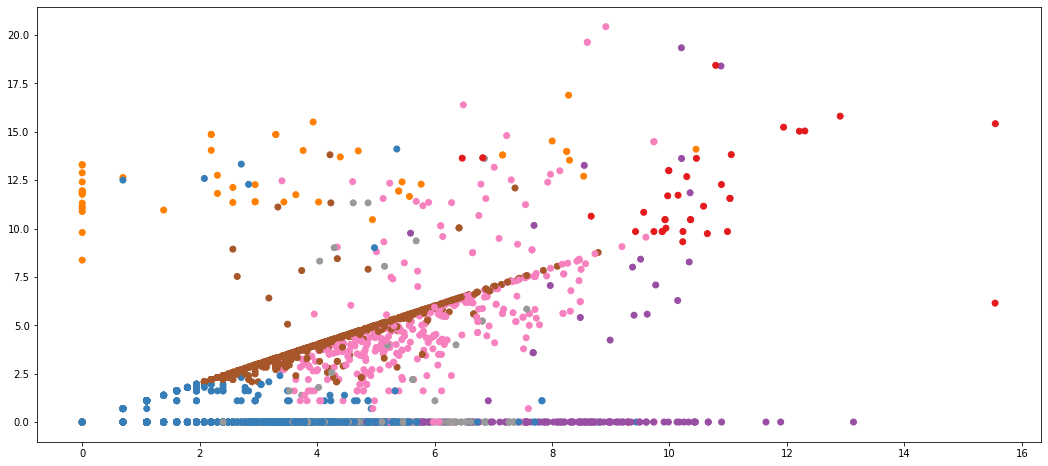

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x_values = [np.log1p(stat['textLines']) for stat in all_stats]
y_values = [np.log1p(stat['rustLines'] + stat['binBytes']) for stat in all_stats]

plt.figure(figsize=(18,8))
plt.scatter(x_values, y_values, c=y_pred, cmap='Set1')
plt.show()

### Histogram of Cluster Sizes

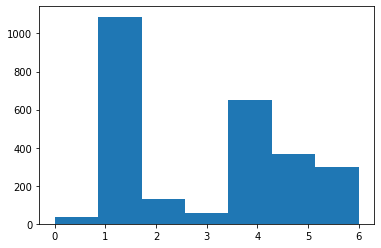

In [6]:
plt.hist(y_pred, num_clusters)
plt.show()

### Reshape the Stats for Easier Handling

In [7]:
for i in range(0, len(y_pred)):
    all_stats[i]['cluster'] = y_pred[i]
    
clusters = [i for i in range(0, num_clusters)]
for i in range(0, num_clusters):
    clusters[i] = [stats for stats in all_stats if stats['cluster'] == i]


### Show Median Statistics for Each Cluster
The table generated here has median values for each cluster to facilitate interpetation of the data. The output fields shown were not included directly as input features, though they are dependent variables.

In [15]:
import numpy as np
import pandas as pd

cluster_names = ['#' + str(i) for i in range(0,len(clusters))]
fields = ['numCommits', 'binFiles', 'textFiles', 'binBytes', 'textLines',
          'javascriptBytePct', 'rustBytePct', 'markdownBytePct', 'jsonBytePct',
          'imgBytePct', 'lockBytePct', 'yarnBytePct', 'htmlBytePct']

for cluster in clusters:
    numCommits = len(cluster)
    for stats in cluster:
        stats['numCommits'] = numCommits

data = [[int(np.round(np.median([stats[field] for stats in cluster]))) for field in fields] for cluster in clusters]
cluster_df = pd.DataFrame(data, index=cluster_names, columns=fields)
cluster_df.transpose()

,#0,#1,#2,#3,#4,#5,#6
numCommits,36,1088,130,59,652,366,298
binFiles,4,0,0,3,0,0,0
textFiles,32,1,8,1,4,10,2
binBytes,87230,0,0,154400,0,0,0
textLines,28642,6,5142,12,56,312,82
javascriptBytePct,1,0,1,0,0,0,100
rustBytePct,0,0,0,0,100,31,0
markdownBytePct,0,0,0,0,0,0,0
jsonBytePct,63,0,95,0,0,0,0
imgBytePct,2,0,0,100,0,0,0


### Interpreting the Clusters

Each datapoint above is a median value of the commits in the cluster. This gives a good idea of what the cluster is about, though there may be devils in the details.

#### Cluster #0: Bulk Commits
These large commits include both text and binary data. These commits might include platform code, template code, or a large, unpacked 3rd party toolkits.

JSON makes up a lot of these commits, which may reflect some sample bias. We sampled projects that include the marine_rs_sdk library. That library is specific to Fluence Rust projects, which may have led to observing a common bulk import across most of the 39 projects.

#### Cluster #1: Bugfixes & Tweaks
These are small commits that address a single problem. Often code, but could be documentation also. Since the chart shows median values and these will be mixed type commits, no single file type has a median over 0. This is the most common type of commit in our observed set.

#### Cluster #2: Big JSON Commits
Without looking at the commits themselves, I can't say whether the JSON is data, configuration, or something else. With a median size of over 5,000 lines, these commits are unlikely to be manual edits.

#### Cluster #3: Image Uploads
There were 59 image upload commits among the 39 projects. While these commits included a median of 3 binary files, they also had a median of one text file, suggesting that these may be documentation or web interface commits.

#### Cluster #4: Rust Development Commits
These commits have a median value of 56 lines, all Rust. These are ordinary Rust developer commits.

#### Cluster #5: Rust Development and Packaging Commits
These commits include about as much Rust code as we would see in a Rust Development Commit, but they also have some "lock" text. ".lock" files are associated with the Rust package manager, called Cargo.

#### Cluster #6: Javascript Development Commits
These commits have a median value of 82 lines, all Javascript. These are ordinary Javascript developer commits.
